#Introduction 
* Over the past four weeks we explored various data preprocessing techniques and solved some regression problems using linear and logistic regression models. The other side of the supervised learning paradigm is classification probelms.
* To solve such problems we are going to consider image classification as a running example and solving it using Perceptron() method.

# Imports
What is the first step?
* Ya, import all necessary packages. For classification problems, we need to import classes and utilities from sklearn.linear_model.
 * This module has implementations for different classification models like `Perceptron, LogisticRegression, svm` and `knn`.

 We also need to import a bunch of model selection utilities from `sklearn.model_selection` module and metrics from `sklearn.metrics` module.

The data preprocessing utilities are imported from `sklearn.preprocessing` modules.

In [2]:
#common inputs
import numpy as np
import pandas as pd
import io
import os
import warnings

#sk learn specific inputs

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

# Handwritten Digit Classification
* We are going to use **Perceptron Classifier** to classify (recognize) given digit images. Since a single perceptron could only be used for binary classification, We consider only two classes in the first half. Eventually we extend it to multi-class setting.
* Suppose we want to recognize whether the given image is of digit zero or not(digit other than zero). Then the problem could be cast as a binary classification problem.
* The first step is to create a dataset that contains a collection of digit images(also called examples, samples) written by humans. Then each image should be labelled properly. Daunting task! 
* Fortunately, we have a standard benchmark dataset called **MNIST**. well, why not make use of itt? Let us import the dataset first...


## Data Loading.

In [3]:
X, y = fetch_openml('mnist_784', version = 1, return_X_y = True)

The data matrix $X$ and the respective label vector $ y$ need to be converted to the numpy array by calling a `to_numpy` method.


In [4]:
X = X.to_numpy()
y = y.to_numpy()


In [5]:
y.shape

(70000,)

* Let's get some information like number of features, number of classes about the dataset.
* Observe that the labels are of string data type not integers

In [6]:
target_names = np.unique(y)
print('Number of samples: {0}, type: {1}'.format(X.shape[0], X.dtype))
print('Number of features: {0}, type: {1}'.format(X.shape[1], X.dtype))
print('Minimum: {0}, Maximum: {1}'.format(np.min(X), np.max(X)))
print('Number of labels : {0}, type: {1}'.format(len(target_names), y.dtype ))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type: float64
Number of features: 784, type: float64
Minimum: 0.0, Maximum: 255.0
Number of labels : 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [7]:
print(np.isnan(X))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


* The **MNIST** dataset is clean and the range of values that each feature can take is also known. Therefore, the samples in the dataset may not require many data preprocessing techniques.
* However, it is often better to scale the range of features between 0 to 1.
* So, we can either use `MinMaxScaler` or `MaxAbsScaler`. They don't make any difference as the image pixels can takes only positive value from 0 to 255.

In [8]:
X = MinMaxScaler().fit_transform(X)
print('Minimum: {0}, Maximum: {1}'.format(np.min(X), np.max(X)))

Minimum: 0.0, Maximum: 1.0


## Data Visualization
Let us pick a few images(the images are already shuffled in the dataset) and display them with their respective labels. As said above, the images are stacked as a row vector of size $ 1 \times 784$ and therefore must be reshaped to the matrix of size $ 28 \times 28$ to display them properly.

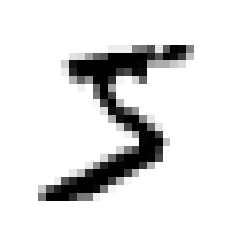

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap ='binary')
plt.axis('off')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


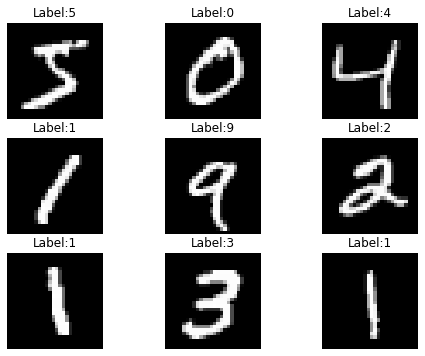

In [10]:
import matplotlib.pyplot as plt
num_images = 9 # Choose a square number 
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor, ncols=factor,figsize=(8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+ i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()



If you closely observe, you can see that there are moderate variations in the appearance of digits (say, digit: 1) These matrices also close to sparse (that is , there are lots of 0(black pixels) in the matrix than non -zero pixels)



## Data Splitting

* Now, we know the details such as number of samples, size of each sample, number of features(784), number of classes (targets) about the dataset.
* So let us split the total number of samples into train and test set in the following ratio: 60000/10000 (that is, 60000 samples in the training set and 10,000 samples in the testing set).
* Since the samples in the data set are already randomly shuffled, we need **not to** shuffle it again. Therefore using `train_test_split()` may be skipped.

# Binary Classification: 0 Detector

 We are going to use **Perceptron Classifier** to classify (recognize) given digit images. Since a single perceptron could only be used for binary classification, We consider only two classes in the first half. Eventually we extend it to multi-class setting.
* Suppose we want to recognize whether the given image is of digit zero or not(digit other than zero). Then the problem could be cast as a binary classification problem.

## Split the data

In [11]:
X_train, y_train = X[:60000] , y[:60000]
X_test, y_test = X[60000:], y[60000:]

##Check imbalance in the data

Before procedding further, we need to check whether the dataset is balanced or imbalanced. We can do it by plotting the distribution of samples in each classes.


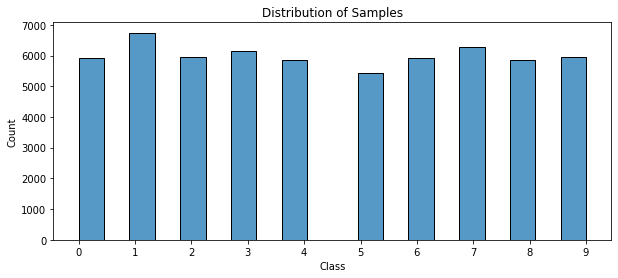

In [12]:
import seaborn as sns
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

## Modifying Labels

* Let us start with a simple classification problem, that is binary classification.
* Since the original label vector contains **10** classes, we need to modify the number of classes to 2.
* Therefore, the label **0** will be changed **1** and all other labels(1-9) will be changed to **-1**.
* We name the label vectors as `y_train_0` and `y_test_0`.

In [13]:
y_train_0 = -1*np.ones(y_train.shape)
y_test_0 = -1*np.ones(y_test.shape)

indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1

indx_1 = np.where(y_test == '0')
y_test_0[indx_1] = 1

## Sanity check: ✅
* Let's display the elements of y_train and y_train_0 to verify whether the labels are properly modified. Of course, we can't verify all the 60000 labels by inspection (unless we have a plenty of time or man power 😃)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


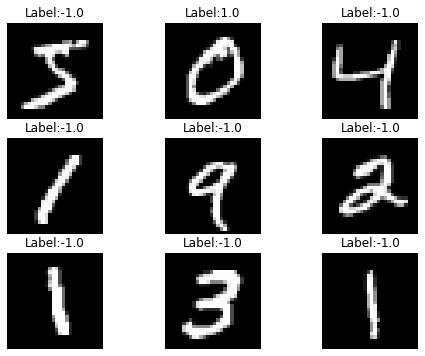

In [14]:

import matplotlib.pyplot as plt
num_images = 9 # Choose a square number 
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor, ncols=factor,figsize=(8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset + i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

##Baseline Models

Enough about Data! 

Let us quickly construct a baseline model with the following rule(you are free to choose different rule)

1. Count number of samples per class.
2. The model **always outputs** the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.


In [15]:
y[:16]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4', '3', '5', '3',
       '6', '1', '7'], dtype=object)

In [16]:
num_pos = np.count_nonzero(y_train_0 == 1)
num_neg = np.count_nonzero(y_train_0 == -1)
print(num_pos, num_neg)

5923 54077


In [17]:
#alternate way
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == -1)[0])


In [18]:
base_clf = DummyClassifier(strategy = 'most_frequent')


In [19]:
base_clf.fit(X_train, y_train_0)
print('Training accuracy: {0:.2f}'.format(base_clf.score(X_train, y_train_0)))
print('Testing accuracy: {0:.2f}'.format(base_clf.score(X_test, y_test_0)))


Training accuracy: 0.90
Testing accuracy: 0.90


* Now the reason is obvious. The model would have predicted 54077 sample correctly just by outputing -1 for all the input samples. Therefore the accuracy will be $ \frac{54077}{60000}=90.12 \% $

This is the reason why "accuracy" alone is not always a good measure!.


#Perceptron model 
$ //  //$ 
Before using perceptron for binary classification, it will be helpful to recall the important concepts (equations) covered in technique course.







##Recap(Theory) 


Let us quickly recap various components in the general settings:

1. **Training data**(features label or $(\mathbf X,y)$ where $y$ is a **discrete** number from a finite set **Features** in this case are **pixel**  values of an image.
2. **Model**: 
\begin{eqnarray} h_w:y&=&\text g(\mathbf w^T 
\mathbf x) \\ 
&=&\text g(w_0+w_1x_1+\ldots + w_mx_m)\end{eqnarray} where,
 * $\mathbf w$ is weight vector in $\mathbb{R}^{(m+1)}$ i.e. it has components: $\{w_0,w_1,\ldots,w_m\}$
 * g$(z)$ is a non-linear activation function given by a signum function:

$$\text g(z)=\begin{cases} +1 ,\text {if} \ z \ge 0 \\
-1, \text {otherwise}(i.e. z \lt 0)\end{cases}$$

3. **Loss function**: Let $ {\hat y}^{(i)} \in \{-1,+1\}$ be the prediction from perceptron and ${\hat y}^{(i)}$ be the actual label for $i-\text{th}$ example. 
$ \\ $

The error is 

$$\text e^{(i)}=\begin{cases} 0 , \ \ \text {if} \ \ {\hat y}^{(i)} = y^{(i)} \\
-\mathbf {w^Tx^{(i)}}y^{(i)}, \text {otherwise}(i.e. {\hat y}^{(i)} \ne y^{(i)})\end{cases}$$

THis can be compactly written as:
\begin{equation} e^{(i)}=\max(-\mathbf{w^Tx^{(i)}}y^{(i)},0)=\max(-h_{\text w }(\mathbf x^{(i)})y^{(i)},0)\end{equation} 

4.**Optimization**:
 * Perceptron learning algorithm
 1. Initialize $\mathbf {\text w}^{(0)}=0$
 2. For each training example $(x^{(i)},y^{(i)})$
  * ${\hat y}^{(i)}=\text{sign}(\mathbf {w^Tx}^{(i)})[\text {calculate the output value}]$
  * $\mathbf w^{(t+1)} := \mathbf w^{(t)}+ \alpha (y^{(i)}-{\hat y}^{(i)})\mathbf x^{(i)}[\text{Update the weights}] $

   Linearly separable examples lead to convergence of the algorithm with zero training loss, else it oscillates.

##Prameters of Perceptron Class

* Let's quickly take a look into the important parameters of the Perceptron()
`class sklearn.linear_model.Perceptron(*,penalty=None, alpha = 0.0001, l1_ration=0.15, fit_intercept = True, max_iter=1000,tol=0.001, shuffle=True, verbose=0, eta0=1.0, n_jobs=None, random_state=0, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5,class_weight=None, warm_start=False).`
* Need not to pay attention to all the arguments and their default values.
* Internally, the API uses the preceptron loss (i.e. it calls **Hinge(0,0)**, where 0.0 is a threshold) and uses SGD to update the weights.
* You may refer to the documentation for more details on the `Perceptron` class.
* The other way of deploying perceptron is to use the general `linear_model.SGDClassifier` with `loss='perceptron'`

* The above loss is termed as hard Hinge-loss (as scores pass through the sign function) and hence we can't use SGD.
* Whereas, SKlearn implements hinge-Loss with the following definition: $\max(0,-wx^iy^i$) and by default calls sgd to minimize the loss.


##Instantiation
* Create an instantiation of binary classifier (bin_clf) and call `fit` method to train the model.

In [20]:
bin_clf = Perceptron(max_iter = 100, random_state = 1729)

##Training and Prediction

* Call the `fit` method to train the model
* It would be nice to plot the iteration vs loss curve for the training. However, sklearn does not have a direct function to plot it.
* Nevertheless, we can workaround this using `partial_fit` method (Which will be demonstrated at the end of the lecture)

In [21]:
bin_clf.fit(X_train, y_train_0)
print('Dimensions of weight vector {0}'.format(bin_clf.coef_.shape))
print('Bias:{0}'.format(bin_clf.intercept_))
print('loss funtion: {0}'.format(bin_clf.loss_function_))

Dimensions of weight vector (1, 784)
Bias:[-108.]
loss funtion: <sklearn.linear_model._sgd_fast.Hinge object at 0x7fca4ede83d0>


In [22]:
y_hat_train_0 = bin_clf.predict(X_train)
print('Training accuracy:{0}'.format(bin_clf.score(X_train, y_train_0)))

Training accuracy:0.99095


In [23]:
y_hat_test_0 = bin_clf.predict(X_test)
print('Testing accuracy:{0}'.format(bin_clf.score(X_test,y_test_0)))

Testing accuracy:0.989


## Displaying Predictions
* Take few images from the testset at random and display it with the corresponding predictions.
* Plot a few images in a single figure window along with their respective **Predictions**. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


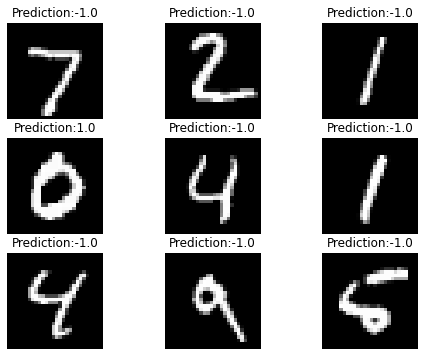

In [24]:
y_hat_test_0 = bin_clf.predict(X_test)
num_images = 9 # choose a square number 
factor = np.int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset + i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X_test[index+j].reshape(28,28),cmap='gray')# we should not use x_train_with_
    ax[i,j].set_title("Prediction:{0}".format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


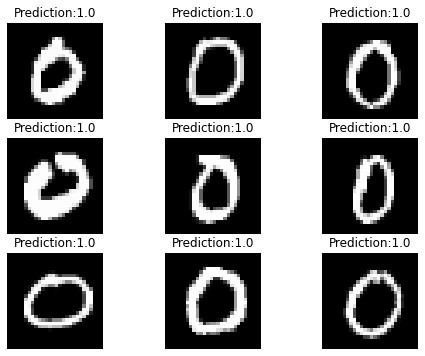

In [25]:
indx_0 = np.where(y_test_0 == 1)
zeroImgs = X_test[indx_0]
zeroLabels = y_hat_test_0[indx_0]
num_images = 9 # choose a square number 
factor = np.int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset + i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray')# we should not use x_train_with_
    ax[i,j].set_title("Prediction:{0}".format(str(zeroLabels[index+j])))
    ax[i,j].set_axis_off()


In [26]:
num_misclassified = np.count_nonzero(zeroLabels == -1)
correct_pred = len(zeroLabels) - num_misclassified

a = correct_pred/len(zeroLabels)
a

0.9193877551020408

* This above score (guess the name of the metric) is less than the accuracy score of the model but it seems preety descent!. 
* Will it be the same if we consider another digit, say, 5 for positive class and all other class as negative?..Of course not. You may cross check it.**(Take it as an excercise)**




##Better Evaluation metrics
* We now know that using the accuracy **alone** to measure the performance of the model is not suitable(especially for imbalanced datasets), so which are the more suitable metrics then?

## Confusion Matrix

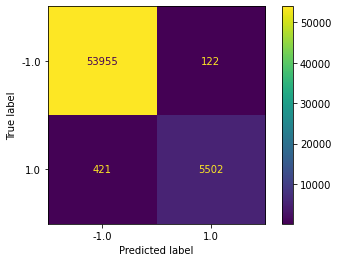

In [27]:
y_hat_train_0 = bin_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0, values_format='.5g',display_labels=bin_clf.classes_)
plt.show()

In [28]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
tp = cf_matrix[1,1]
fp = cf_matrix[0,1]

In [29]:
precision = tp/(tp+fp) 
print("Precision:",precision)
recall = tp/(tp+fn)
print('Recall:',recall)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('accuracy:',accuracy)

Precision: 0.9783072546230441
Recall: 0.9289211548201924
accuracy: 0.99095


* The precision is close to 0.98. Despite it, we still want to increase the precision. Let's come back to this later.
* In general, we would like to know whether the model under consideration with the set hyper-parameters is a good one for a given problem.


## Cross Validation
* Well to address this, we have to use cross-validation folds and measure the same metrics across these folds for different values of hyper-parameters.
* However, perceptron does not any hyperparameters other than the learning rate.
* For the moment, we set the learning rate to its default value. Later, we use `GridSearchCV` to find the better value for the learning rate.

In [30]:
bin_clf = Perceptron(max_iter = 100, random_state = 1729)
scores = cross_validate(bin_clf, X_train, y_train_0, scoring = ['precision', 'recall', 'f1'], cv = 5, return_estimator = True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.10844803, 2.22080612, 1.57199812, 1.41558647, 1.78147292]),
 'score_time': array([0.04563022, 0.04277349, 0.0413394 , 0.0408349 , 0.04945636]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


* **NOTE** 

The perceptron estimator passed as an argument to the function `cross_validate` is internally cloned `num_fold (cv=5)` times and fitted independently on each fold. (you can check this by setting `warm_start=True`)

* Compute the average and standard deviation of scores for all three metrics on (k=5) folds to measure the generalization!.


In [31]:
print('f1,             avg:{0:.2f},  std:{1:.3f}'.format(scores['test_f1'].mean(), scores['test_f1'].std()))
print('precision,      avg:{0:.2f},  std:{1:.2f}'.format(scores['test_precision'].mean(), scores['test_precision'].std()))
print('recall,         avg:{0:.2f},  std:{1:.2f}'.format(scores['test_recall'].mean(), scores['test_recall'].std()))

f1,             avg:0.94,  std:0.013
precision,      avg:0.96,  std:0.01
recall,         avg:0.92,  std:0.03


* Let us pick the first estimator returned by the cross-validate function.
* So, we can hope that the model might also perform well on test data. Let's check that out..


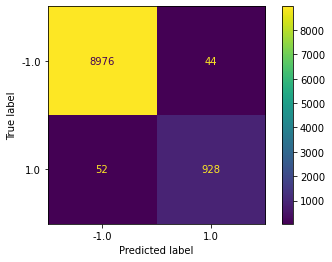

In [32]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format='.5g')

In [33]:
print('Precision:{0:.2f}'.format(precision_score(y_test_0,y_hat_test_0)))
print('recall:{0:.2f}'.format(recall_score(y_test_0,y_hat_test_0)))



Precision:0.95
recall:0.95


## General method using `cross_val_predict`

**WAY-2 for Generalization:**
(Optional)
* There is an **another approach** of getting predicted labels via cross-validation and using it to measure the generalization. 
* In this case, each sample in the dataset will be part of only one test set in the splitted folds.

In [34]:
y_hat_train_0 = cross_val_predict(bin_clf, X_train, y_train_0, cv = 5)

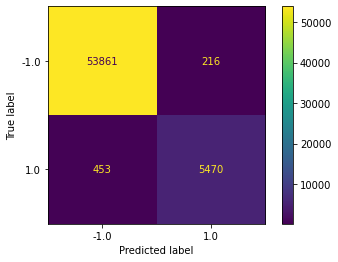

In [35]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0)

In [36]:
cf_matrix = cm_display.confusion_matrix 
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]


In [37]:
precision = tp/(tp+fp) 
print("Precision:",precision)
recall = tp/(tp+fn)
print('Recall:',recall)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('accuracy:',accuracy)


Precision: 0.9620119591980303
Recall: 0.9235184872530812
accuracy: 0.98885


* Compare the precision and recall score obtained by the above method with that of the previous method(i.e. using `cross_validate`) 
* Finally, we can print all these scores as a report using the `classification_report` function

In [38]:
print('Precision:{0:.2f}'.format(precision_score(y_train_0,y_hat_train_0))) 
print('Recall:{0:.2f}'.format(recall_score(y_train_0,y_hat_train_0)))
print('-'*53)
print(classification_report(y_train_0,y_hat_train_0))

Precision:0.96
Recall:0.92
-----------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



##Precision/Recall Tradeoff 

* Often time we need to make a trade off between precision and recall scores of a model.
* It depends on the problem at hand.
* It is important to note that we should **not** pass the **predicted labels** as input to `precision_recall_curve` function, instead we need to pass the probability scores or the output from the decision function!.
* The `Perceptron()` class contains a `decision_function` method, therefore we can make use of it.
* Then, internally the decision scores are sorted, **tps** and **fps** will be computed by changing the threshold from index[0] to index [-1].
* Let us compute the scores from decision function.

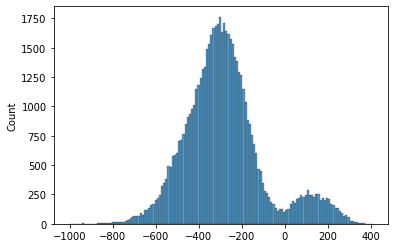

In [39]:
bin_clf = Perceptron(random_state  = 1729)
bin_clf.fit(X_train , y_train_0)

y_scores = bin_clf.decision_function(X_train)

sns.histplot(data = y_scores)
plt.show()


Can you think why there are so many negative values than the positives ?
**Hint** Class-Imbalance
* Suppose threshold takes the value of -600, then all the samples having score greater than -600 is set to 1(Positive label) and less than it is set to -1(neg label) 
* Therefore, the number of False Positives will be increased. This will in turn reduce the precision score to a greater extent.
* On the otherhand, if the threshold takes the value of say 400, Then, the number of False negatives will be increase and hence the recall will reduce to a greater extent.

* Let's see it in action.

In [40]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0,y_scores,pos_label=1)

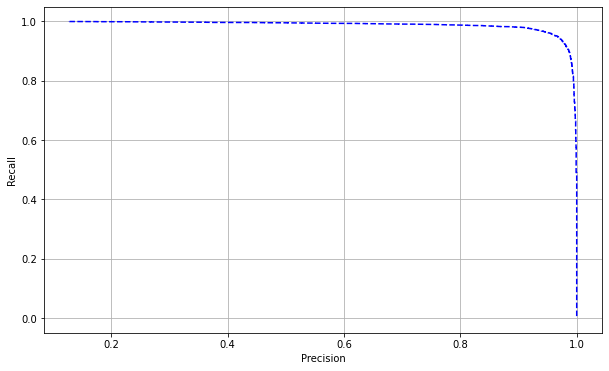

In [41]:

plt.figure(figsize=(10,6))
plt.plot(precisions[:-1],recalls[:-1],"b--")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

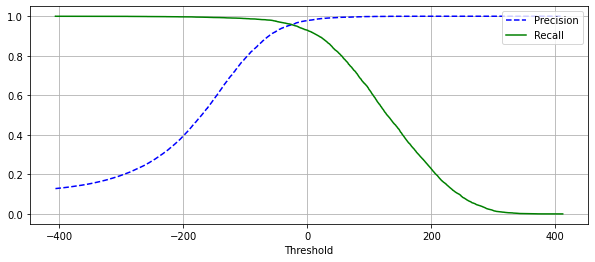

In [42]:
plt.figure(figsize=(10,4))
plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


In [53]:
#get the index of threshold around zero 
idx_th = np.where(np.logical_and(thresholds >0, thresholds <1))
print("precision for zero threshold:",precisions[idx_th[0][0]])
print('recalls',recalls[idx_th[0][1]])

precision for zero threshold: 0.9783072546230441
recalls 0.9289211548201924


In [44]:
idx_th = np.where(np.logical_and(thresholds >0, thresholds <1))
idx_th

(array([40536, 40537, 40538, 40539, 40540, 40541, 40542]),)

In [49]:
idx_1 = np.where(np.logical_and(thresholds >-50, thresholds <0))


In [50]:
len(idx_1[0])

621

In [55]:
for i in range(len(idx_1[0])):
  if precisions[idx_1[0][i]] == recalls[idx_1[0][i]]:
                print( precisions[idx_1[0][i]], recalls[idx_1[0][i]],thresholds[idx_1[0][i]])

                


0.9574539929089988 0.9574539929089988 -24.779577085736747
